In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import norm, binom
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
import tqdm
import pickle

qfile = pickle.load(open('../data/qfile.pkl', 'rb')) # information about each questions
user_info = pickle.load(open('../user-study-results/user-response.pkl', 'rb')) # individual user responses
df = pd.read_csv('../user-study-results/user-stats.csv', header=0) # statistics based on individual user responses
user_qual = pd.read_csv('../user-study-results/user-qualitative.csv', header=0) # qualitative responses from the users

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Data count per group
groups = ['control', 'shap', 'bertsum', 'cooccur', 'semantic']
for tt in groups:
    print(tt, df[df['type'] == tt].shape[0])
print(df.shape[0])

control 58
shap 53
bertsum 55
cooccur 51
semantic 54
271


# Hypothesis Testing

In [3]:
control = df[df['type'] == 'control']['hard_acc'].values
shap = df[df['type'] == 'shap']['hard_acc'].values
bertsum = df[df['type'] == 'bertsum']['hard_acc'].values
cooccur = df[df['type'] == 'cooccur']['hard_acc'].values
semantic = df[df['type'] == 'semantic']['hard_acc'].values

def perm_test(x, y, rs=0):
    def statistic(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    res = scipy.stats.permutation_test(
        (x, y), 
        statistic, 
        vectorized=True,
        alternative='two-sided',
        random_state=rs
    )
    return res

tests = [
    perm_test(control, shap),
    perm_test(control, bertsum),
    perm_test(control, cooccur),
    perm_test(control, semantic),
]

alpha = 0.05
rej, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    [x.pvalue for x in tests],
    alpha=alpha,
    method='hs'
)

print(rej, pvals_corrected)

data = dict()

for tt in groups:
    data[tt] = {
        'easy-acc': df[df['type'] == tt]['easy_acc'].values,
        'hard-acc': df[df['type'] == tt]['hard_acc'].values,
        'total-acc': df[df['type'] == tt]['total_acc'].values,
        'easy-time': df[df['type'] == tt]['easy_time_avg'].values,
        'hard-time': df[df['type'] == tt]['hard_time_avg'].values,
        'total-time': df[df['type'] == tt]['total_time_avg'].values
    }

[ True  True  True  True] [0.00159904 0.0056     0.002997   0.002997  ]


control 0.4655172413793103 (0.4195314973529184, 0.5115029854057022) 0.9310344827586207 (0.8952970983074844, 0.9667718672097569)
shap 0.3522012578616352 (0.31574805866678346, 0.38865445705648693) 0.8679245283018868 (0.812542816157355, 0.9233062404464186)
bertsum 0.36666666666666664 (0.3178604234086785, 0.4154729099246548) 0.9227272727272727 (0.8789145625446264, 0.966539982909919)
cooccur 0.5800653594771241 (0.5343326870899991, 0.6257980318642491) 0.9411764705882353 (0.8986849425713499, 0.9836679986051207)
semantic 0.5864197530864198 (0.537387761998803, 0.6354517441740366) 0.9305555555555556 (0.8867894459780095, 0.9743216651331017)


Text(0.5, 1.0, 'Average Accuracy on Questions')

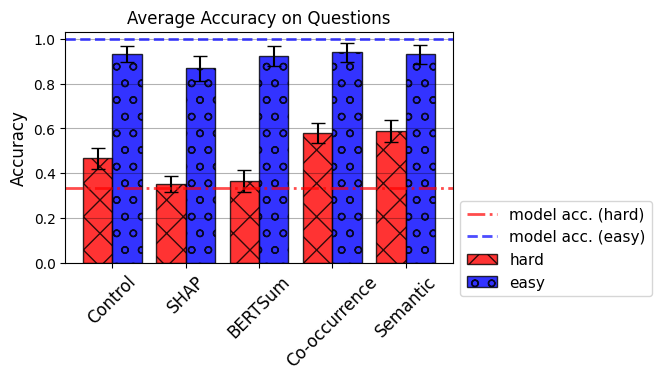

In [4]:
# Accuracy Plot
f, axs = plt.subplots(figsize=(5,3))
xticklabels = ['Control', 'SHAP', 'BERTSum', 'Co-occurrence', 'Semantic']
groups = ['control', 'shap', 'bertsum', 'cooccur', 'semantic']
table_elem = dict()
for x, tt in enumerate(groups):
    dh = data[tt]['hard-acc']
    de = data[tt]['easy-acc']
    avg_hard = np.mean(dh)
    avg_easy = np.mean(de)
    intv_hard = scipy.stats.norm.interval(alpha=0.95, loc=avg_hard, scale=scipy.stats.sem(dh))
    intv_easy = scipy.stats.norm.interval(alpha=0.95, loc=avg_easy, scale=scipy.stats.sem(de))
    yer1 = avg_hard - intv_hard[0]
    yer2 = avg_easy - intv_easy[0]
    print(tt, avg_hard, intv_hard, avg_easy, intv_easy)
    table_elem[tt] = ([avg_hard, intv_hard[0], intv_hard[1]],
                      [avg_easy, intv_easy[0], intv_easy[1]])
    axs.bar([x-0.2], [avg_hard], yerr=yer1, edgecolor='black', capsize=5, width=0.4, label='hard', color='red', hatch='x', alpha=0.8)
    axs.bar([x+0.2], [avg_easy], yerr=yer2, edgecolor='black', capsize=5, width=0.4, label='easy', color='blue', hatch='o', alpha=0.8)
axs.axhline(np.mean(df['hard_score_based_acc']), linewidth=2, linestyle='-.', color='red', alpha=0.7)
axs.axhline(np.mean(df['easy_score_based_acc']), linewidth=2, linestyle='--', color='blue', alpha=0.7)
axs.set_xticks(range(5))
axs.set_xticklabels(xticklabels, fontsize=12, rotation=45)
ylabel = 'Accuracy'
axs.set_ylabel(ylabel, fontsize=12)
axs.legend(
    ['model acc. (hard)', 'model acc. (easy)', 'hard', 'easy'],
    bbox_to_anchor =(1.0, 0.3),
    prop={'size': 11}
)
axs.grid(True, axis='y', color='k', alpha=0.3)
axs.set_title('Average Accuracy on Questions')
#plt.savefig('accuracy.pdf', dpi=200, bbox_inches='tight')

control 41.65864655172414 34.37349568965517 38.01607112068966
shap 38.74464622641509 29.947712264150944 34.34617924528302
bertsum 48.90663484848485 35.97258636363636 42.439610606060604
cooccur 36.7670522875817 29.03250490196078 32.89977859477124
semantic 32.85102314814815 26.550416666666667 29.70071990740741


Text(0.5, 1.0, 'Average Time Spent on Questions')

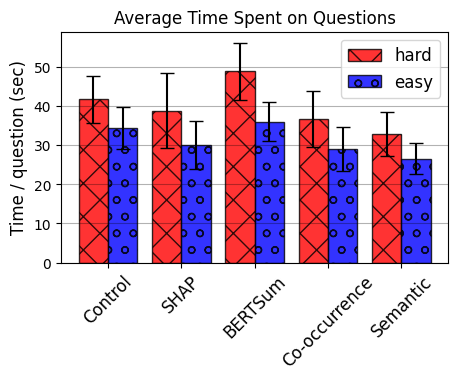

In [5]:
# Time Plot
f, axs = plt.subplots(figsize=(5,3))
for x, tt in enumerate(groups):
    dh = data[tt]['hard-time']
    de = data[tt]['easy-time']
    avg_hard = np.mean(dh)
    avg_easy = np.mean(de)
    print(tt, avg_hard, avg_easy, (avg_hard+avg_easy)/2)
    intv_hard = scipy.stats.norm.interval(alpha=0.95, loc=avg_hard, scale=scipy.stats.sem(dh))
    intv_easy = scipy.stats.norm.interval(alpha=0.95, loc=avg_easy, scale=scipy.stats.sem(de))
    yer1 = avg_hard - intv_hard[0]
    yer2 = avg_easy - intv_easy[0]
    axs.bar([x-0.2], [avg_hard], yerr=yer1, edgecolor='black', capsize=5, width=0.4, label='hard', color='red', hatch='x', alpha=0.8)
    axs.bar([x+0.2], [avg_easy], yerr=yer2, edgecolor='black', capsize=5, width=0.4, label='easy', color='blue', hatch='o', alpha=0.8)
axs.set_xticks(range(5))
axs.set_xticklabels(xticklabels, fontsize=12, rotation=45)
ylabel = 'Time / question (sec)'
axs.set_ylabel(ylabel, fontsize=12)
axs.legend(['hard', 'easy'], prop={'size':12})
axs.grid(True, axis='y', color='k', alpha=0.3)
axs.set_title('Average Time Spent on Questions')
#plt.savefig('time.pdf', dpi=200, bbox_inches='tight')

# Time vs Accuracy

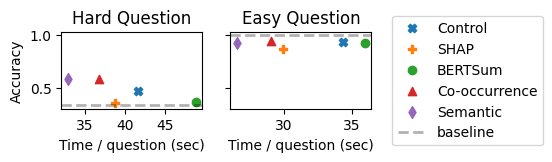

In [6]:
f, axs = plt.subplots(1,2, figsize=(4,1), sharey=True)
markertype = ['X','P','o','^','d']
for i, tt in enumerate(groups):
    accs = data[tt]['hard-acc']
    times = data[tt]['hard-time']
    axs[0].scatter(np.mean(times), np.mean(accs), label=xticklabels[i], marker=markertype[i])
axs[0].axhline(np.mean(df['hard_score_based_acc']), linewidth=2, label='baseline',linestyle='--', color='black', alpha=0.3)

for i, tt in enumerate(groups):
    accs = data[tt]['easy-acc']
    times = data[tt]['easy-time']
    axs[1].scatter(np.mean(times), np.mean(accs), label=xticklabels[i], marker=markertype[i])
axs[1].axhline(np.mean(df['easy_score_based_acc']), linewidth=2, linestyle='--', label='baseline', color='black', alpha=0.3)

axs[0].set_xlabel('Time / question (sec)')
axs[0].set_ylabel('Accuracy')
axs[1].set_xlabel('Time / question (sec)')
axs[0].set_title('Hard Question')
axs[1].set_title('Easy Question')
axs[1].legend(
    bbox_to_anchor =(1.1, 1.3),
    prop={'size': 10}
)
#plt.savefig('time-acc.pdf', dpi=200, bbox_inches='tight')

# Qualitative Reponses

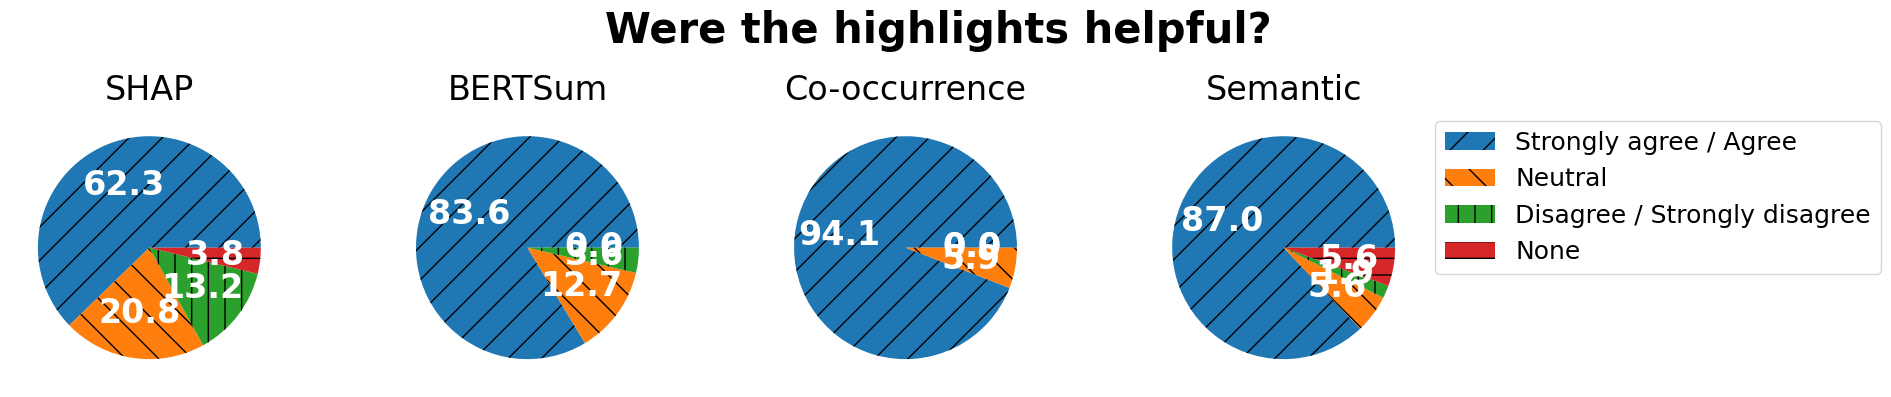

In [7]:
import collections

f, axs = plt.subplots(1,4, figsize=(20,4))
f.suptitle('Were the highlights helpful?', fontsize=30, fontweight='bold')
question = 'Q_helpful_highlights'
labels = ['Strongly agree', 'Agree', 'Neutral', 'Disagree', 'Strongly disagree', 'None']
hatch = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*"]
for i, tt in enumerate(groups[1:]):
    row = int(i / 2)
    col = int(i % 2)
    data = user_qual[user_qual['type']==tt][question]
    data = data.fillna('None').values
    freq = collections.Counter(data)
    for k in labels:
        freq[k] = freq[k] / len(data) * 100
    fdata = [freq[k] for k in labels]
    fdata2 = [0, 0, 0, 0]
    fdata2[0] = fdata[0] + fdata[1]
    fdata2[1] = fdata[2]
    fdata2[2] = fdata[3] + fdata[4]
    fdata2[3] = fdata[5]
    def func(vals):
        if vals < 0:
            return ''
        return '{:.1f}'.format(vals)
    d = axs[i].pie(fdata2, 
               autopct=lambda x : func(x), 
               #labels=[''] * len(fdata2), 
               textprops=dict(color='w', fontsize=24, fontweight='bold'))
    for j, wedge in enumerate(d[0]):
        wedge.set_hatch(hatch[j])
    axs[i].set_title(xticklabels[i+1], fontsize=24)
axs[i].legend(
    labels=['Strongly agree / Agree', 'Neutral', 'Disagree / Strongly disagree', 'None'], 
    bbox_to_anchor =(1,1), 
    fontsize=18,
    ncol=1
)
plt.tight_layout()
#plt.savefig('helpful.pdf', dpi=200, bbox_inches='tight')

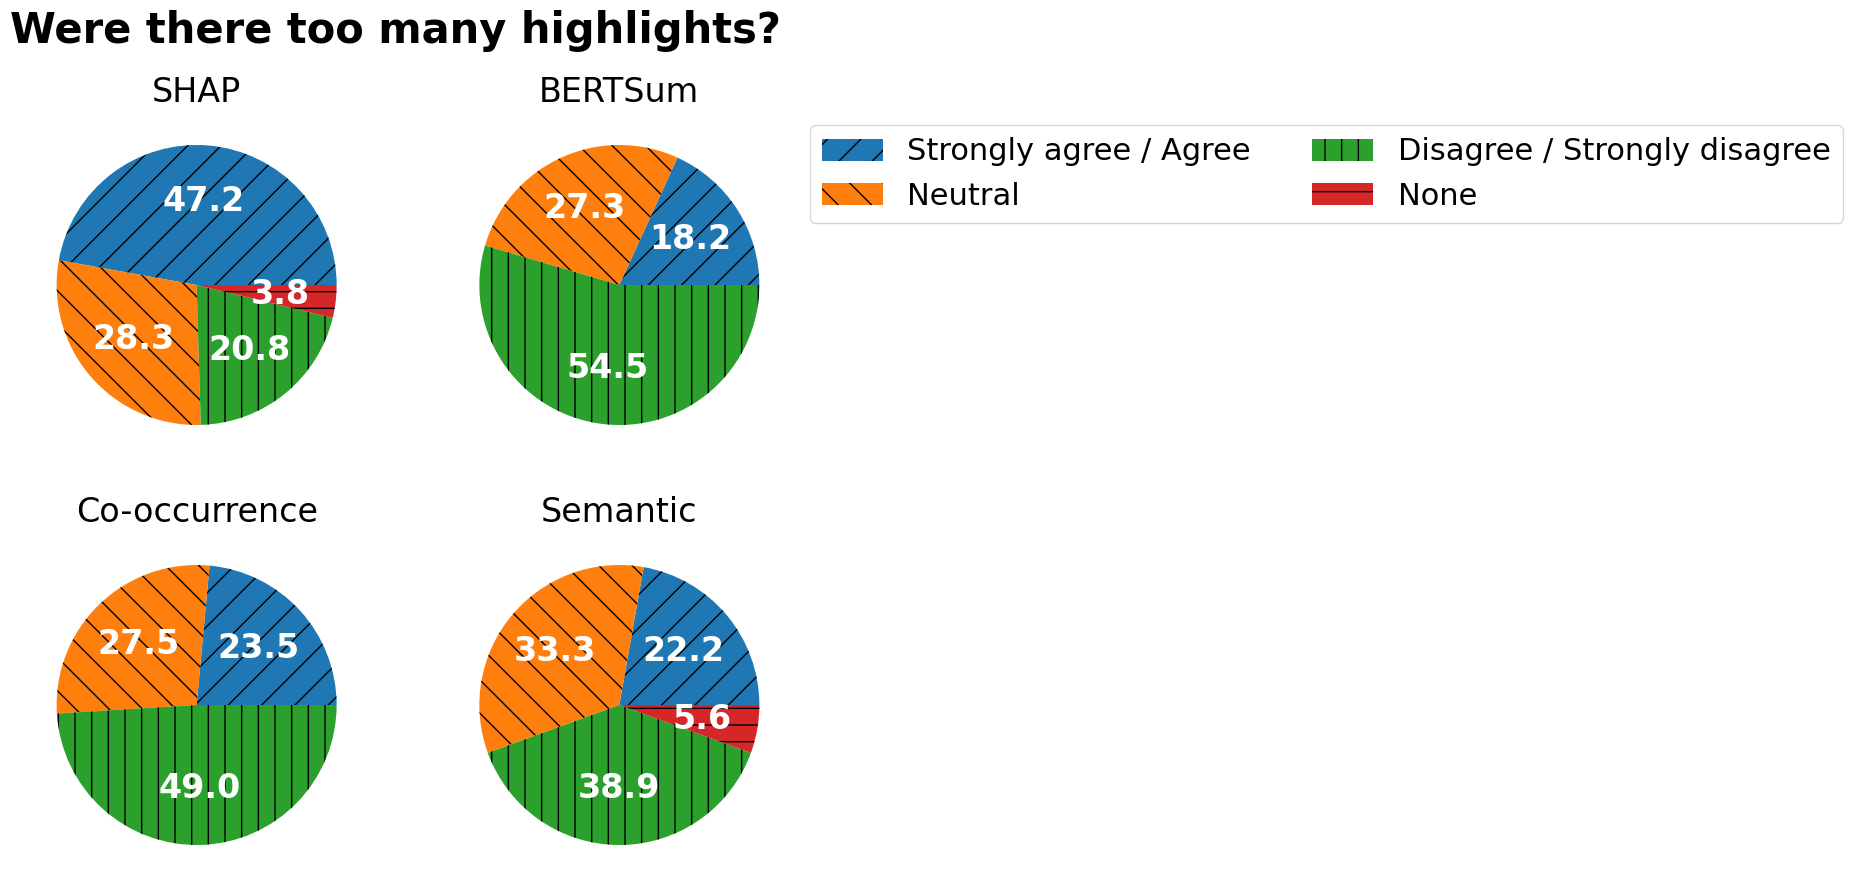

In [8]:
f, axs = plt.subplots(2,2, figsize=(10, 10))
f.suptitle('Were there too many highlights?', fontsize=30, fontweight='bold')
question = 'Q_too_many_highlight'
labels = ['Strongly agree', 'Agree', 'Neutral', 'Disagree', 'Strongly disagree', 'None']
hatch = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*"]
for i, tt in enumerate(groups[1:]):
    row = int(i / 2)
    col = int(i % 2)
    data = user_qual[user_qual['type']==tt][question]
    data = data.fillna('None').values
    freq = collections.Counter(data)
    for k in labels:
        freq[k] = freq[k] / len(data) * 100
    fdata = [freq[k] for k in labels]
    fdata2 = [0, 0, 0, 0]
    fdata2[0] = fdata[0] + fdata[1]
    fdata2[1] = fdata[2]
    fdata2[2] = fdata[3] + fdata[4]
    fdata2[3] = fdata[5]
    def func(vals):
        if vals == 0:
            return ''
        return '{:.1f}'.format(vals)
    d = axs[row][col].pie(fdata2, 
               autopct=lambda x : func(x), 
               textprops=dict(color='w', fontsize=24, fontweight='bold'))
    for j, wedge in enumerate(d[0]):
        wedge.set_hatch(hatch[j])
    axs[row][col].set_title(xticklabels[i+1], fontsize=24)
axs[0][1].legend(
    labels=['Strongly agree / Agree', 'Neutral', 'Disagree / Strongly disagree', 'None'], 
    bbox_to_anchor =(1,1), 
    fontsize=22,
    ncol=2
)
plt.tight_layout()
#plt.savefig('toomany.pdf', dpi=200, bbox_inches='tight')

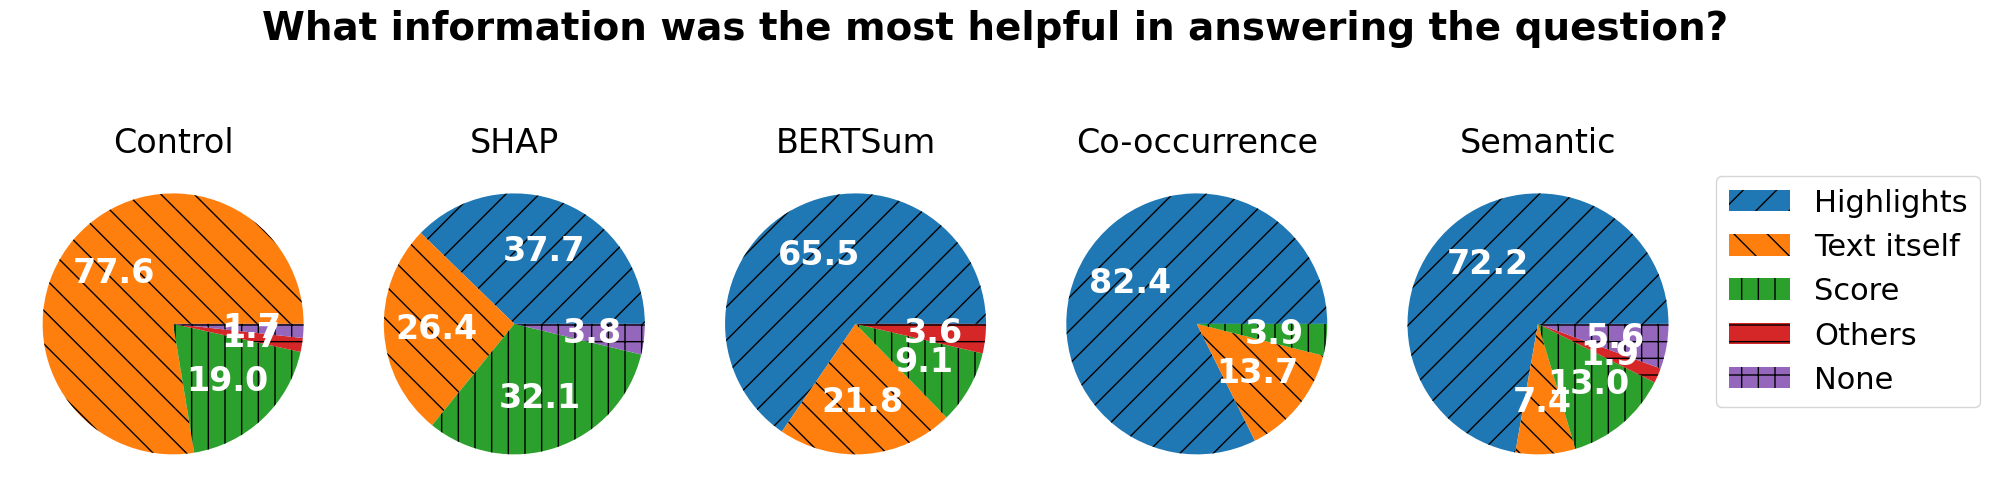

In [9]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
f.suptitle(
    'What information was the most helpful in answering the question?', 
    fontsize=28, 
    fontweight='bold'
)
question = 'Q_what_info_helpful'
labels = ['Highlights', 'Text itself', 'Score', 'Others', 'None']
hatch = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*"]
for i, tt in enumerate(groups[:]):
    row = int(i / 2)
    col = int(i % 2)
    data = user_qual[user_qual['type']==tt][question]
    data = data.fillna('None').values
    freq = collections.Counter(data)
    for k in labels:
        freq[k] = freq[k] / len(data) * 100
    fdata = [freq[k] for k in labels]
    fdata2 = fdata
    def func(vals):
        if vals <= 0:
            return ''
        return '{:.1f}'.format(vals)
    d = axs[i].pie(fdata2, 
               autopct=lambda x : func(x), 
               #labels=[''] * len(fdata2), 
               textprops=dict(color='w', fontsize=24, fontweight='bold'))
    for j, wedge in enumerate(d[0]):
        wedge.set_hatch(hatch[j])
    axs[i].set_title(xticklabels[i], fontsize=24)
axs[-1].legend(
    labels=['Highlights', 'Text itself', 'Score', 'Others', 'None'], 
    bbox_to_anchor =(1,1), 
    fontsize=22,
    ncol=1
)
plt.tight_layout()
#plt.savefig('whathelpful.pdf', dpi=200, bbox_inches='tight')

# Problem Type Analysis

In [10]:
# Add anccuracy and time info for each questions
all_probs = qfile.keys()
prob_response = dict()
for tt in groups:
    prob_response[tt] = dict()
    for p in all_probs:
        prob_response[tt][p] = [0,0,0,0,0,0,0]
    for u, v in user_info.items():
        if v['type'] == tt:
            for p, c, a, t in zip(v['probs'], v['correct'], v['ans'], v['time']):
                prob_response[tt][p][0] += c
                prob_response[tt][p][1] += 1
                prob_response[tt][p][2+a] += 1
                prob_response[tt][p][-1] += t
                
    for p in all_probs:
        qfile[p][tt] = prob_response[tt][p][0] / prob_response[tt][p][1]
        qfile[p][tt+'-ans'] = prob_response[tt][p][2:-1] # total selected responses for each choice
        qfile[p][tt+'-time'] = prob_response[tt][p][-1] / np.sum(qfile[p][tt+'-ans'])# total selected responses for each choice

In [11]:
qfile

{22: {'type': 'easy-ans',
  'ans': 1,
  'score-correct': True,
  'control': 0.9583333333333334,
  'control-ans': [1, 23, 0, 0],
  'control-time': 41.64975,
  'shap': 0.8636363636363636,
  'shap-ans': [0, 19, 2, 1],
  'shap-time': 26.918181818181814,
  'bertsum': 1.0,
  'bertsum-ans': [0, 19, 0, 0],
  'bertsum-time': 36.195263157894736,
  'cooccur': 0.9523809523809523,
  'cooccur-ans': [0, 20, 1, 0],
  'cooccur-time': 25.002380952380957,
  'semantic': 0.9444444444444444,
  'semantic-ans': [0, 17, 1, 0],
  'semantic-time': 19.970444444444446},
 62: {'type': 'easy-ans',
  'ans': 2,
  'score-correct': True,
  'control': 1.0,
  'control-ans': [0, 0, 29, 0],
  'control-time': 34.343862068965514,
  'shap': 0.782608695652174,
  'shap-ans': [0, 0, 18, 5],
  'shap-time': 27.822043478260877,
  'bertsum': 0.96,
  'bertsum-ans': [0, 0, 24, 1],
  'bertsum-time': 31.298920000000003,
  'cooccur': 0.8823529411764706,
  'cooccur-ans': [0, 2, 15, 0],
  'cooccur-time': 23.368764705882352,
  'semantic': 1.

In [12]:
# problem with minimum average accuracy across all methods
d = []
hardq = list(qfile.keys())[10:]
easyq = list(qfile.keys())[:10]
for p in qfile.keys():
    accs = [qfile[p][tt] for tt in groups]
    d.append(np.mean(accs))
np.mean(d[:10]), np.mean(d[10:])

(0.9185537454063967, 0.4627327182324048)

In [13]:
# which method did the best/worst for each question?
winners = []
losers = []
for i, p in enumerate(hardq):
    accs = [qfile[p][tt] for tt in groups]
    wm = np.max(accs)
    lm = np.min(accs)
    print(p,accs)
    winner = groups[np.argmax(accs)]
    loser = groups[np.argmin(accs)]
    winners.append((winner, wm))
    losers.append((loser, lm))
for z, w, l in zip(hardq, winners, losers):
    print(z, w, l)

26 [0.7941176470588235, 0.45161290322580644, 0.7428571428571429, 0.5925925925925926, 0.8064516129032258]
81 [0.3125, 0.15625, 0.12903225806451613, 0.42424242424242425, 0.5405405405405406]
98 [0.6129032258064516, 0.6774193548387096, 0.32, 0.6774193548387096, 0.7878787878787878]
73 [0.3142857142857143, 0.1794871794871795, 0.11764705882352941, 0.4444444444444444, 0.76]
115 [0.5121951219512195, 0.5454545454545454, 0.4411764705882353, 0.7941176470588235, 0.7777777777777778]
235 [0.825, 0.8125, 0.8157894736842105, 1.0, 0.7096774193548387]
325 [0.9333333333333333, 0.7878787878787878, 0.59375, 0.71875, 0.717948717948718]
75 [0.5897435897435898, 0.5142857142857142, 0.35135135135135137, 0.75, 0.68]
90 [0.6486486486486487, 0.4, 0.47058823529411764, 0.5882352941176471, 0.4666666666666667]
276 [0.2413793103448276, 0.2222222222222222, 0.16666666666666666, 0.7096774193548387, 0.6756756756756757]
14 [0.59375, 0.5714285714285714, 0.6875, 0.5806451612903226, 0.6857142857142857]
129 [0.32, 0.111111111111

In [14]:
# on which problem did methods on average do worst/best
hardq[np.argmin(d[10:])], hardq[np.argmax(d[10:])]

(290, 235)

0.101986885
0.037056867


Text(0.5, 1.0, 'Max Affinity Score Difference \n between Correct and Wrong Articles')

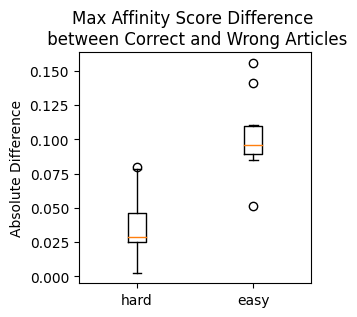

In [15]:
# similarity score distribution btw easy and hard
exps = pickle.load(open('../output/text_exp_semantic.pkl', 'rb')) # load explanation file to refer to affinity scores

easy_scores = []
for idx in easyq:
    s1 = exps[idx]['score_t1_s1']
    s2 = exps[idx]['score_t2_s1']
    scores = np.array([s1] + s2).flatten()
    easy_scores.append(scores)
easy_scores = np.array(easy_scores)
diff1 = np.abs(easy_scores[:,0] - easy_scores[:,1])
diff2 = np.abs(easy_scores[:,0] - easy_scores[:,2])
easy_diffs = []
for x1, x2 in zip(diff1, diff2):
    easy_diffs.append(max(x1, x2))
#easy_diffs = np.hstack((diff1, diff2))
print(np.mean(easy_diffs))

hard_scores = []
for idx in hardq:
    s1 = exps[idx]['score_t1_s1']
    s2 = exps[idx]['score_t2_s1']
    scores = np.array([s1] + s2).flatten()
    hard_scores.append(scores)
hard_scores = np.array(hard_scores)
diff1 = np.abs(hard_scores[:,0] - hard_scores[:,1])
diff2 = np.abs(hard_scores[:,0] - hard_scores[:,2])
hard_diffs = []
for x1, x2 in zip(diff1, diff2):
    hard_diffs.append(max(x1, x2))
#hard_diffs = np.hstack((diff1, diff2))
print(np.mean(hard_diffs))

# box plot
f, axs = plt.subplots(figsize=(3,3))
axs.boxplot([hard_diffs, easy_diffs])
axs.set_xticklabels(['hard', 'easy'])
axs.set_ylabel('Absolute Difference')
axs.set_title('Max Affinity Score Difference \n between Correct and Wrong Articles')